# Building a CNN Based Sign Language Model

## Step 1: Import Libraries

In [1]:
# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim

# Pandas and NumPy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib for visualizing data
import matplotlib.pyplot as plt

# Scikit-learn for splitting the dataset
from sklearn.model_selection import train_test_split

# PyTorch utilities for creating datasets and data loaders
from torch.utils.data import Dataset, DataLoader

# Torchvision for image transformations
from torchvision.transforms import transforms

# Import functional API for ReLU
import torch.nn.functional as F

# RoC Curve display for evaluation
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

from PIL import Image
import torch

## Step 2: Load and Explore the Dataset

In [2]:
train_data = pd.read_csv("sign_mnist_train.csv")
test_data = pd.read_csv("sign_mnist_test.csv")

# Print the shape and inspect the data
print(f"Original training data shape: {train_data.shape}")
print(f"Original testing data shape: {test_data.shape}")
print(train_data.head())

Original training data shape: (27455, 785)
Original testing data shape: (7172, 785)
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133     

Here we will visualize the data to see what we're working with:

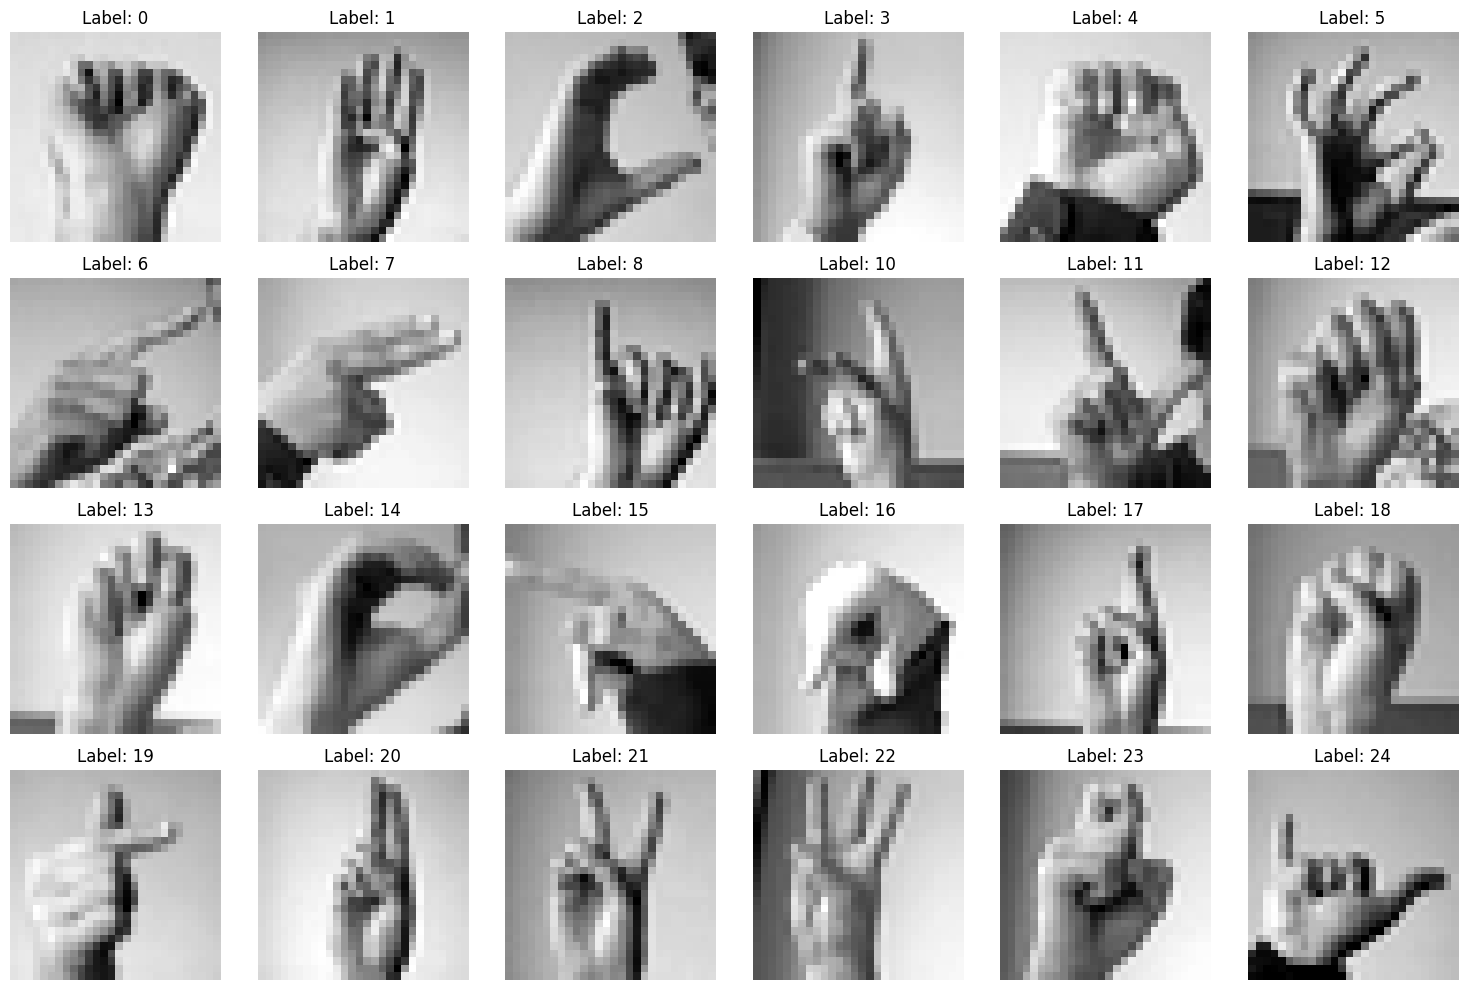

In [6]:
unique_labels = train_data['label'].unique()

plt.figure(figsize=(15, 10))

for i, label in enumerate(sorted(unique_labels)):
    # Get the first row with the specific label
    example_row = train_data[train_data['label'] == label].iloc[0, 1:].values  # Pixels only
    example_image = example_row.reshape(28, 28)  # Reshape to 28x28 grid

    # Plot the image
    plt.subplot(4, 6, i + 1)  # Adjust the grid size (4x6 for 24 labels)
    plt.imshow(example_image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**Note**: As you can see, we have labels **24** labels (0-23). However there are **26** letters in the alphabet. It is important to note that the letter `J` which would be label 9 and `Z` which would be label 25 do not exsist as they use hand motions and therefore can not be included into the set.  

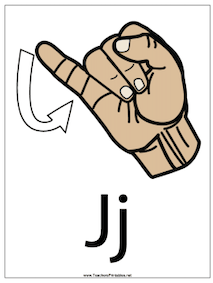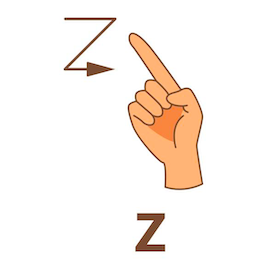

## Step 3: Subsample the data

* Working with a small sample (like 10%) was very helpful to test the model. It made sure the code ran smoothly without taking forever.
* Every time there was a bug or an improvement, it was much faster to handle with a smaller dataset.

In [7]:
# Subsample 10% of the data
train_data_sample = train_data.sample(frac=1, random_state=42)
test_data_sample = test_data.sample(frac=1, random_state=42)

print(f"Sampled training data shape: {train_data_sample.shape}")
print(f"Sampled testing data shape: {test_data_sample.shape}")

Sampled training data shape: (27455, 785)
Sampled testing data shape: (7172, 785)


## Step 4: Prepare the Data
Separate the **labels** and **pixel data**, **normalize the pixel values**, and **reshape for CNN input**.

In [8]:
# Separate labels and pixel data for subsampled training data
train_labels_sample = train_data_sample['label'].values
train_images_sample = train_data_sample.drop('label', axis=1).values

# Separate labels and pixel data for subsampled testing data
test_labels_sample = test_data_sample['label'].values
test_images_sample = test_data_sample.drop('label', axis=1).values

# Normalize pixel values (0-255 -> 0-1)
train_images_sample = train_images_sample / 255.0
test_images_sample = test_images_sample / 255.0

# Reshape images for CNN input -> (Batch Size, Channels, Height, Width)
train_images_sample = train_images_sample.reshape(-1, 1, 28, 28).astype('float32')
test_images_sample = test_images_sample.reshape(-1, 1, 28, 28).astype('float32')

# Verify shapes
print(f"Train images shape: {train_images_sample.shape}")
print(f"Test images shape: {test_images_sample.shape}")

Train images shape: (27455, 1, 28, 28)
Test images shape: (7172, 1, 28, 28)


In [9]:
# Check unique values and range of labels
print("Training labels unique values:", np.unique(train_labels_sample))
print("Testing labels unique values:", np.unique(test_labels_sample))

# Check if any label is out of range
print(f"Are all training labels valid? {np.all((train_labels_sample >= 0) & (train_labels_sample <= 23))}")
print(f"Are all testing labels valid? {np.all((test_labels_sample >= 0) & (test_labels_sample <= 23))}")

Training labels unique values: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Testing labels unique values: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Are all training labels valid? False
Are all testing labels valid? False


## Step 5: Create a PyTorch Dataset
Define a custom PyTorch Dataset class to handle the sampled data data.


In [10]:
# Define a custom PyTorch Dataset
class SignLanguageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)  # Convert images to tensors
        self.labels = torch.tensor(labels, dtype=torch.long)     # Convert labels to tensors

    def __len__(self):
        return len(self.images)  # Number of samples

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]  # Return one image-label pair

# Create training and testing datasets
train_dataset = SignLanguageDataset(train_images_sample, train_labels_sample)
test_dataset = SignLanguageDataset(test_images_sample, test_labels_sample)

## Step 6: Create DataLoaders
Use DataLoader to handle batching, shuffling, and loading the data efficiently.


In [11]:
from torch.utils.data import DataLoader

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify the number of batches
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

# Inspect a batch of data
images, labels = next(iter(train_loader))
print(f"Batch images shape: {images.shape}")  # Expected: (64, 1, 28, 28)
print(f"Batch labels shape: {labels.shape}")  # Expected: (64,)

Number of training batches: 429
Number of testing batches: 113
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])



## Step 7: Define the CNN Model
Define the Convolutional Neural Network (CNN) architecture.


In [12]:
"""
def init(self): Initializes the SignLanguageCNN model layers.

def forward(self, x): Defines the forward pass of the CNN.

Parameters:
- x (torch.Tensor):
  Input tensor representing a batch of grayscale images.
  Shape: (batch_size, 1, 28, 28).

Returns:
- torch.Tensor:
  Output tensor containing the logits for 24 classes.
  Shape: (batch_size, 24).

Forward Pass Steps:
1. Convolutional Layer 1:
    -> Applies conv1 to the input, followed by ReLU activation and max-pooling.
    -> Input shape: (batch_size, 1, 28, 28) → Output shape: (batch_size, 32, 14, 14).
2. Convolutional Layer 2:
    -> Applies conv2 to the output of the previous layer, followed by ReLU activation and max-pooling.
    -> Input shape: (batch_size, 32, 14, 14) → Output shape: (batch_size, 64, 7, 7).
3. Flattening:
    -> Flattens the output of the pooling layer to prepare it for fully connected layers.
    -> Input shape: (batch_size, 64, 7, 7) → Output shape: (batch_size, 3136).
4. Fully Connected Layer 1:
    -> Applies fc1 to the flattened tensor, followed by ReLU activation and dropout.
    -> Input shape: (batch_size, 3136) → Output shape: (batch_size, 128).
5. Fully Connected Layer 2:
    -> Applies fc2 to the output of fc1 to produce logits for 24 classes.
    -> Input shape: (batch_size, 128) → Output shape: (batch_size, 24).

"""

# Define the CNN model
class SignLanguageCNN(nn.Module):
    def __init__(self):
        super(SignLanguageCNN, self).__init__()
        # Convolutional layer 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input: (1, 28, 28), Output: (32, 28, 28)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: (32, 28, 28), Output: (64, 28, 28)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces dimensions: Output: (64, 14, 14)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flattened input: 64 * 7 * 7
        self.fc2 = nn.Linear(128, 24)  # 24 output classes (A-Y, excluding J and Z)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layer 1 -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Convolutional layer 2 -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        # Fully connected layer 1 -> ReLU -> Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # Fully connected layer 2
        x = self.fc2(x)
        return x

# Initialize the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SignLanguageCNN().to(device)

# Print the model architecture
print(model)

SignLanguageCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=24, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)



## Step 8: Define the Optimizer and Loss Function


In [13]:
# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer # Learning rate: 0.001
criterion = nn.CrossEntropyLoss()                     # Cross-entropy loss for classification # Suitable for classification


## Step 9: Remove problematic labels



In [14]:
print("Training labels unique values:", np.unique(train_labels_sample))
print("Testing labels unique values:", np.unique(test_labels_sample))

Training labels unique values: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Testing labels unique values: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


The presence of label 24 in both training and testing datasets confirms why you’re encountering the IndexError: Target 24 is out of bounds. The model’s output layer expects labels in the range 0–23 (for 24 classes), but label 24 exceeds this range.

The solution wil be to remove al 24.

In [15]:
# Filter out invalid labels (24) from training and testing datasets
valid_train_indices = train_labels_sample < 24
valid_test_indices = test_labels_sample < 24

train_labels_sample = train_labels_sample[valid_train_indices]
train_images_sample = train_images_sample[valid_train_indices]

test_labels_sample = test_labels_sample[valid_test_indices]
test_images_sample = test_images_sample[valid_test_indices]

# Recreate datasets
train_dataset = SignLanguageDataset(train_images_sample, train_labels_sample)
test_dataset = SignLanguageDataset(test_images_sample, test_labels_sample)

# Recreate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Updated training labels unique values:", np.unique(train_labels_sample))
print("Updated testing labels unique values:", np.unique(test_labels_sample))

Updated training labels unique values: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Updated testing labels unique values: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


## Step 10: Train the Model
Train the model using the subsampled data.

In [16]:
# Training the CNN
num_epochs = 10  # Number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Reset the running loss for this epoch

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass: compute predictions
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 1.7571
Epoch [2/10], Loss: 0.6912
Epoch [3/10], Loss: 0.4307
Epoch [4/10], Loss: 0.2962
Epoch [5/10], Loss: 0.2278
Epoch [6/10], Loss: 0.1841
Epoch [7/10], Loss: 0.1559
Epoch [8/10], Loss: 0.1395
Epoch [9/10], Loss: 0.1261
Epoch [10/10], Loss: 0.1149


## Step 11: Evaluate the Model
Evaluate the model on the subsampled test data.

In [23]:
# Evaluate the model
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

misclassified = []
true_labels = []
cnn_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get class with the highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        cnn_predictions.extend(predicted.cpu().numpy())

        # Identify misclassified examples
        for i in range(len(labels)):
            if predicted[i] != labels[i]:  # If prediction does not match the label
                misclassified.append((images[i].cpu(), predicted[i].cpu().item(), labels[i].cpu().item()))

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 92.49%


In [24]:
from sklearn.metrics import classification_report


# Verify that predictions and true labels have the same length
print(f"Length of true labels: {len(true_labels)}")
print(f"Length of predictions: {len(cnn_predictions)}")

# Generate a classification report
num_classes = len(np.unique(true_labels))  # This will Automatically determine the nmber of classes
target_names = [f"Class {i}" for i in range(num_classes)]

print("Classification Report:")
print(classification_report(true_labels, cnn_predictions, target_names=target_names))

Length of true labels: 6840
Length of predictions: 6840
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      1.00      0.96       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      0.95      0.98       310
     Class 3       0.94      1.00      0.97       245
     Class 4       0.97      0.94      0.96       498
     Class 5       0.94      1.00      0.97       247
     Class 6       0.94      0.89      0.91       348
     Class 7       0.92      0.95      0.94       436
     Class 8       1.00      0.93      0.96       288
     Class 9       1.00      0.87      0.93       331
    Class 10       0.82      1.00      0.90       209
    Class 11       0.98      0.87      0.92       394
    Class 12       0.92      0.74      0.82       291
    Class 13       1.00      1.00      1.00       246
    Class 14       0.95      1.00      0.97       347
    Class 15       0.91      1.00      0.95       164
  

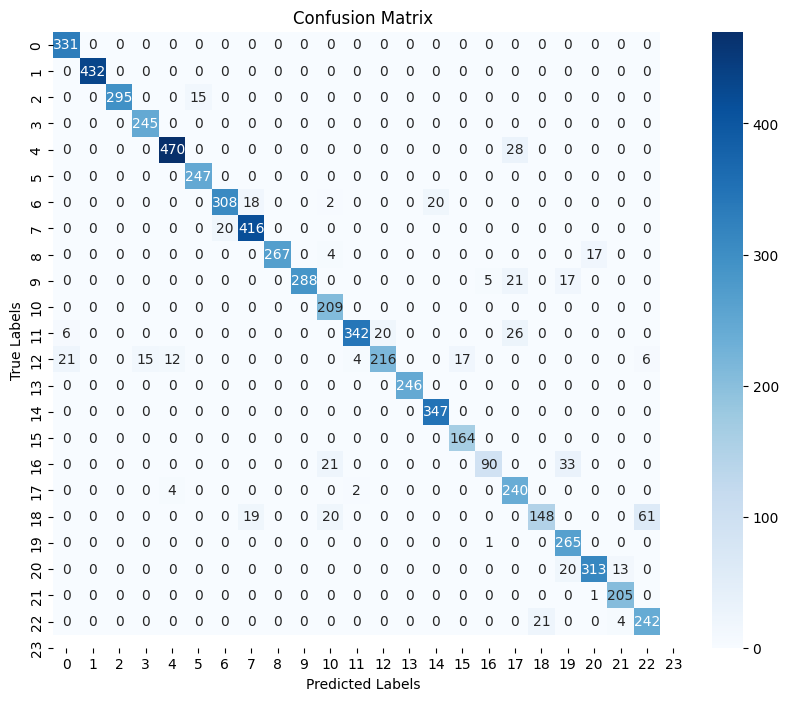

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate CNN predictions
cnn_predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        cnn_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(true_labels, cnn_predictions)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(24), yticklabels=range(24))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

We can see that the model performs relatively well. Certain labels are incorrectly predicted. Many pictures get miss identified as 17 often. 12 also gets misidentified as many other fist like letters.

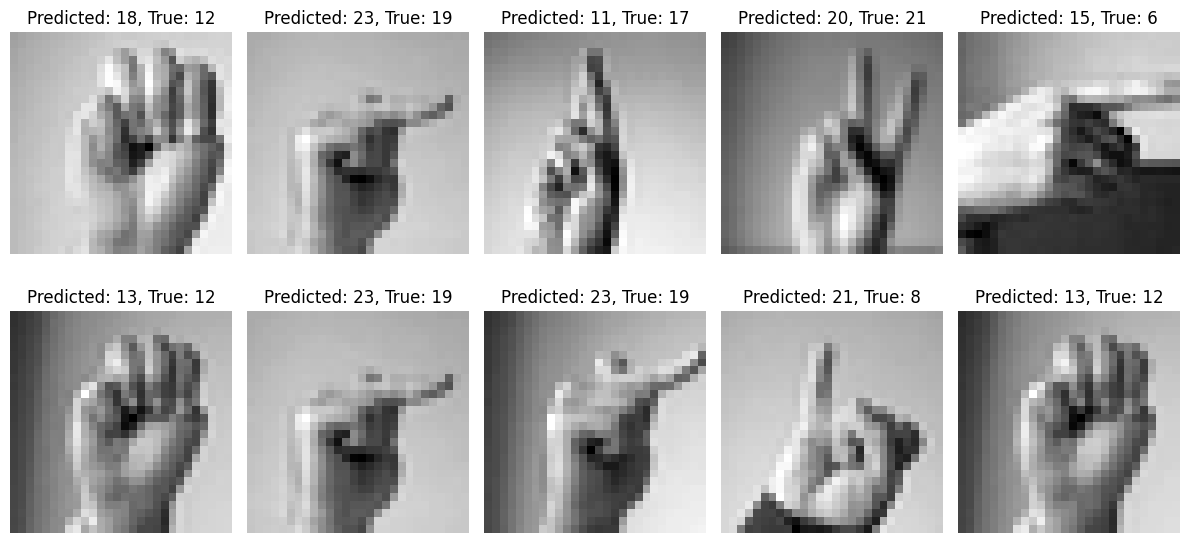

In [28]:
num_examples = min(10, len(misclassified))  # Show up to 10 examples
plt.figure(figsize=(12, 6))

for i in range(num_examples):
    img, predicted_label, true_label = misclassified[i]
    img = img.squeeze()  # Remove channel dimension (1, 28, 28) -> (28, 28)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_label}, True: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


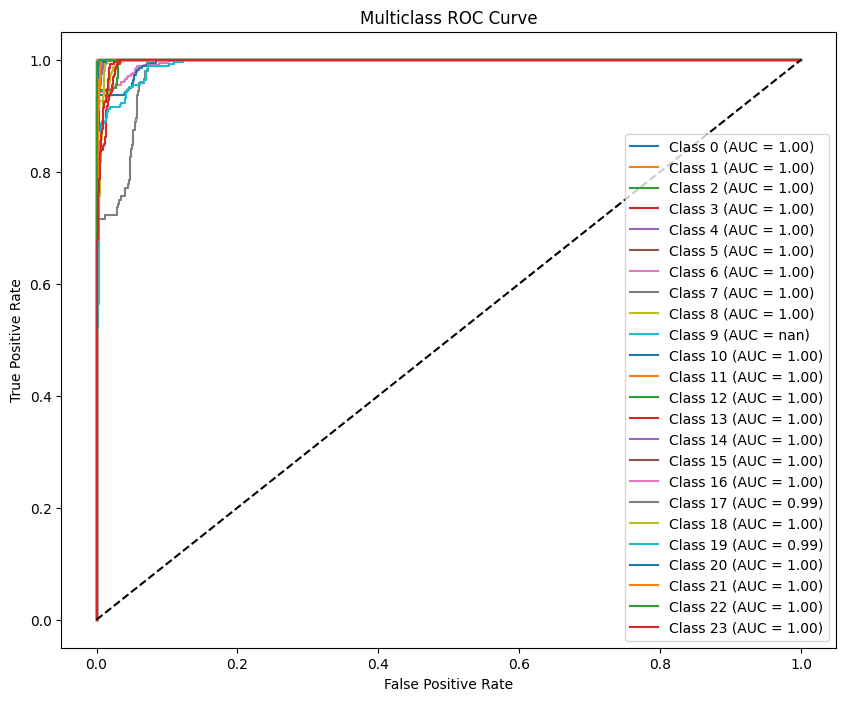

In [22]:
# Binarize the labels for ROC computation
num_classes = 24
true_labels_binarized = label_binarize(true_labels, classes=range(num_classes))
cnn_predictions_proba = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        cnn_predictions_proba.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Convert to NumPy array
cnn_predictions_proba = np.array(cnn_predictions_proba)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], cnn_predictions_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.title("Multiclass ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.show()

In the ROC plot above we can see that Class 17 performs notably worse than the other classes. We can note that for future optimazation and look into how to optimize this class.